# Automated ML for time series predicion

We used one of the dataset in [Numenta Anomaly Benchmark (NAB)](https://github.com/numenta/NAB) for demo, i.e. NYC taxi passengers dataset, which contains 10320 records, each indicating the total number of taxi passengers in NYC at a corresonponding time spot. 

In [1]:
%load_ext autoreload
%autoreload 2

## 0. Helper function definations

In [2]:
# plot the predicted values and actual values (for the test data)
def plot_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=1):
    # target column of dataframe is "value"
    # past sequence length is 50
    pred_value = pred_df[value_col].values
    true_value = test_df[value_col].values[past_seq_len:]
    fig, axs = plt.subplots(figsize=(12, 5))

    axs.plot(pred_df[dt_col], pred_value, color='red', label='predicted values')
    axs.plot(test_df[dt_col][past_seq_len:], true_value, color='blue', label='actual values')
    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

In [3]:
# plot results of multi step forecasting
# plot at most five values for better view
# plot the predicted values and actual values (for the test data)
def plot_less_five_step_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=1):
    fig, axs = plt.subplots(figsize=(12, 5))
    target_value = test_df[value_col].values[past_seq_len:]
    axs.plot(test_df[dt_col][past_seq_len:], target_value, color='blue', label='actual values')

    value_cols=["{}_{}".format(value_col, i) for i in range(min(pred_df.shape[1] - 1, 5))]
    time_delta = pred_df[dt_col][1] - pred_df[dt_col][0]
    plot_color = ["g", "r", "c", "m", "y"]
    for i in range(len(value_cols)):
        pred_value = pred_df[value_cols[i]].values
        pred_dt = pred_df[dt_col].values + time_delta * i
        axs.plot(pred_dt, pred_value, color=plot_color[i], label='predicted values' + str(i))

    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

In [4]:
# plot results of multi step forecasting
# plot result of multi step forecasting
# plot the predicted values and actual values (for the test data)
def plot_first_last_step_result(test_df, pred_df, dt_col="datetime", value_col="value", past_seq_len=1):
    fig, axs = plt.subplots(figsize=(12, 5))
    target_value = test_df[value_col].values[past_seq_len:]
    axs.plot(test_df[dt_col][past_seq_len:], target_value, color='blue', label='actual values')

    value_cols=["{}_{}".format(value_col, i) for i in range(pred_df.shape[1] - 1)]
    time_delta = pred_df[dt_col][1] - pred_df[dt_col][0]
  
    pred_value_first = pred_df[value_cols[0]].values
    pred_dt_first = pred_df[dt_col].values
    axs.plot(pred_dt_first, pred_value_first, color="g", label='first predicted values')
 
    pred_value_last = pred_df[value_cols[-1]].values
    pred_dt_last = pred_df[dt_col].values + time_delta * (len(value_cols)-1)
    axs.plot(pred_dt_last, pred_value_last, color="r", label='last predicted values')

    axs.set_title('the predicted values and actual values (for the test data)')

    plt.xlabel(dt_col)
    plt.xticks(rotation=45)
    plt.ylabel('number of taxi passengers')
    plt.legend(loc='upper left')
    plt.show()

## 1. load data

In [5]:
import os
import pandas as pd
import numpy as np

import matplotlib
matplotlib.use('Agg')
%pylab inline
import matplotlib.dates as md
from matplotlib import pyplot as plt

Populating the interactive namespace from numpy and matplotlib


Now we download the dataset and load it into a pandas dataframe.
Run the script `$ANALYTICS_ZOO_HOME/dist/bin/data/NAB/nyc_taxi/get_nyc_taxi.sh` to download the raw data

In [6]:
# load nyc taxi data
try:
    dataset_path = os.getenv("ANALYTICS_ZOO_HOME")+"/bin/data/NAB/nyc_taxi/nyc_taxi.csv"
    raw_df = pd.read_csv(dataset_path)
except Exception as e:
    print("nyc_taxi.csv doesn't exist")
    print("you can run $ANALYTICS_ZOO_HOME/bin/data/NAB/nyc_taxi/get_nyc_taxi.sh to download nyc_taxi.csv")

Below are some example records of the data

In [7]:
raw_df.head(5)

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


Convert string timestamp to TimeStamp

In [9]:
df = pd.DataFrame(pd.to_datetime(raw_df.timestamp))
df["value"] = raw_df["value"]
df.head()

,timestamp,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


Change column name timestamp to datetime

In [ ]:
df.set_index("timestamp", inplace=True)
df.index.name = "datetime"
df = df.reset_index()
df.head()

You can use train_val_test_split to split the whole dataset into train/val/test sets. There will be two columns in the output dataframe: "datetime" and "value", where the data type of "datetime" column is datetime64.

In [ ]:
from zoo.automl.common.util import train_val_test_split
train_df, val_df, test_df = train_val_test_split(df, val_ratio=0.1, test_ratio=0.1)

In [ ]:
train_df.describe()

In [ ]:
train_df.head()

# shape of the dataframe
print("The shape of train_df is", train_df.shape)
print("The shape of val_df is", val_df.shape)
print("The shape of test_df is", test_df.shape)

In [10]:
df.set_index("timestamp", inplace=True)
df.index.name = "datetime"
df = df.reset_index()
df.head()

,datetime,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


You can use train_val_test_split to split the whole dataset into train/val/test sets. There will be two columns in the output dataframe: "datetime" and "value", where the data type of "datetime" column is datetime64.

In [11]:
from zoo.automl.common.util import train_val_test_split
train_df, val_df, test_df = train_val_test_split(df, val_ratio=0.1, test_ratio=0.1)

In [12]:
train_df.describe()

,value
count,8256.000000
mean,15421.585514
std,6871.989592
min,1431.000000
25%,11040.000000
50%,17014.500000
75%,20032.250000
max,39197.000000


In [13]:
train_df.head()

,datetime,value
0,2014-07-01 00:00:00,10844
1,2014-07-01 00:30:00,8127
2,2014-07-01 01:00:00,6210
3,2014-07-01 01:30:00,4656
4,2014-07-01 02:00:00,3820


In [14]:
# shape of the dataframe
print("The shape of train_df is", train_df.shape)
print("The shape of val_df is", val_df.shape)
print("The shape of test_df is", test_df.shape)

The shape of train_df is (8256, 2)
The shape of val_df is (1032, 2)
The shape of test_df is (1032, 2)


No handles with labels found to put in legend.


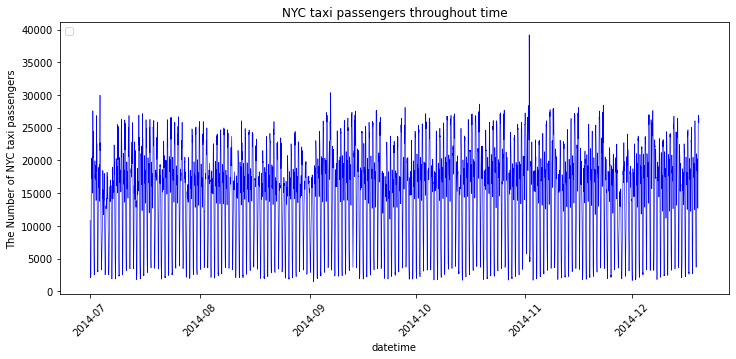

In [15]:
# visualisation of anomaly throughout time in train_df
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

fig, ax = plt.subplots(figsize=(12, 5))
# pd.plotting.deregister_matplotlib_converters()

ax.plot(train_df['datetime'], train_df['value'], color='blue', linewidth=0.6)
ax.set_title('NYC taxi passengers throughout time')

plt.xlabel('datetime')
plt.xticks(rotation=45) 
plt.ylabel('The Number of NYC taxi passengers')
plt.legend(loc='upper left')
plt.show()

## 2. Train and validation

You can use analytices zoo automl to predict time series data by simply define a `TimeSequencePredictor`. 

We use feature tools to generate features from the given datetime. The generated features are \['HOUR', 'DAY', 'MONTH'. 'IS_AWAKE', 'IS_BUSY_HOURS'\]. Our feature space comprises these generated features as well as the original inputs such as \['datetime','value','extra_features'\].  

Currently, We use RNN to learn from 50 previous values, and predict just the 1 next value. You can specify the sequence length to predict while creating `TimeSequencePredictor` with arg: `future_seq_len`.

In [16]:
# build time sequence predictor
from zoo.automl.regression.time_sequence_predictor import *

# you need to specify the name of datetime column and target column
# The default names are "datetime" and "value" respectively.
tsp = TimeSequencePredictor(dt_col="datetime",
                            target_col="value",
                            extra_features_col=None)

In [17]:
from zoo import init_spark_on_local
from zoo.ray import RayContext
sc = init_spark_on_local(cores=4)
ray_ctx = RayContext(sc=sc, object_store_memory="1g")
ray_ctx.init()

Current pyspark location is : /Users/liuruolan/spark-2.4.3-bin-hadoop2.7/python/lib/pyspark.zip/pyspark/__init__.py
Start to getOrCreate SparkContext


2020-06-04 10:11:50,554	INFO resource_spec.py:212 -- Starting Ray with 2.39 GiB memory available for workers and up to 0.93 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).


Successfully got a SparkContext


2020-06-04 10:11:50,993	INFO services.py:1148 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '192.168.101.6',
 'redis_address': '192.168.101.6:13820',
 'object_store_address': '/tmp/ray/session_2020-06-04_10-11-50_542075_4652/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-06-04_10-11-50_542075_4652/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-06-04_10-11-50_542075_4652'}

In [18]:
%%time
# fit train_df and validate with val_df, return the best trial as pipeline.
# the default recipe is SmokeRecipe,which runs one epoch and one iteration with only 1 random sample.
# you can change recipe by define `recipe` in `fit`. The recipes you can choose are SmokeRecipe, RandomRecipe, GridRandomRecipe and BayesRecipe.
pipeline = tsp.fit(train_df,
                   validation_df=val_df,
                   metric="mse",
                   recipe=RandomRecipe(look_back=(2, 4)))
print("Training completed.")

Trial name,status,loc,batch_size,dropout,dropout_1,dropout_2,latent_dim,lr,lstm_1_units,lstm_2_units,model,past_seq_len,selected_features,iter,total time (s)
train_func_00000,TERMINATED,,1024,0.446487,0.395819,0.491682,128,0.00262221,128,32,Seq2seq,4,"[""IS_WEEKEND(datetime)"", ""HOUR(datetime)"", ""WEEKDAY(datetime)""]",10,22.2133


best log dir is  /Users/liuruolan/ray_results/automl/train_func_0_batch_size=1024,dropout=0.44649,dropout_1=0.39582,dropout_2=0.49168,latent_dim=128,lr=0.0026222,lstm_1_units=128,lstm_2020-06-04_10-11-53ixmnaz21
The best configurations are:
selected_features : ["IS_WEEKEND(datetime)", "HOUR(datetime)", "WEEKDAY(datetime)"]
model : Seq2seq
lstm_1_units : 128
dropout_1 : 0.3958194202734888
lstm_2_units : 32
dropout_2 : 0.49168224454421733
latent_dim : 128
dropout : 0.4464872460582088
lr : 0.0026222074042782104
batch_size : 1024
epochs : 5
past_seq_len : 4
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instr

## 3. Test

In [19]:
# predict test_df with the best trial
pred_df = pipeline.predict(test_df)

In [20]:
pred_df.head(5)

,datetime,value
0,2015-01-10 14:00:00,22321.889148
1,2015-01-10 14:30:00,21421.196677
2,2015-01-10 15:00:00,22054.195722
3,2015-01-10 15:30:00,22793.882384
4,2015-01-10 16:00:00,23488.906236


In [21]:
# prediction value start from 50
test_df[50:55]

,datetime,value
50,2015-01-11 13:00:00,21296
51,2015-01-11 13:30:00,20381
52,2015-01-11 14:00:00,19508
53,2015-01-11 14:30:00,19210
54,2015-01-11 15:00:00,18255


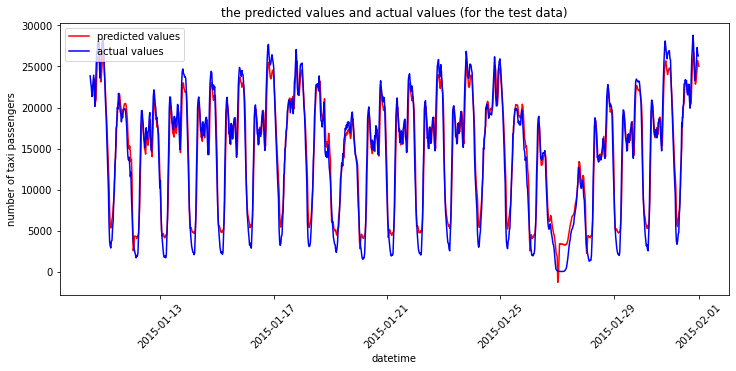

In [22]:
# plot the predicted values and actual values
plot_result(test_df, pred_df)

In [23]:
# evaluate test_df
mse, smape = pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 3171802.837769492
Evaluate: the smape value is 9.703021169644428


## 4. save and restore

We provide save and restore interface to save the pipeline with the best trial for easily rebuilding.

In [24]:
# save the pipeline with best trial
pipeline.save("/tmp/saved_pipeline/my.ppl")

Pipeline is saved in /tmp/saved_pipeline/my.ppl


'/tmp/saved_pipeline/my.ppl'

In [25]:
from zoo.automl.pipeline.time_sequence import load_ts_pipeline
new_pipeline = load_ts_pipeline("/tmp/saved_pipeline/my.ppl")

Restore pipeline from /tmp/saved_pipeline/my.ppl


In [26]:
# you can do predict and evaluate again
# we use test_df as input in order to compare results before and after restoration 
new_pred = new_pipeline.predict(test_df)

In [27]:
new_pred.head(5)

,datetime,value
0,2015-01-10 14:00:00,22321.889148
1,2015-01-10 14:30:00,21421.196677
2,2015-01-10 15:00:00,22054.195722
3,2015-01-10 15:30:00,22793.882384
4,2015-01-10 16:00:00,23488.906236


In [28]:
# evaluate test_df
mse, smape = new_pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 3171802.837769492
Evaluate: the smape value is 9.703021169644428


## 5. continue training

We support continue training with incremental data using the best configuration searched and the trained model.

In [29]:
# review the initialization infomation if needed
new_pipeline.describe()

**** Initialization info ****
future_seq_len: 1
dt_col: datetime
target_col: value
extra_features_col: None
drop_missing: True



In [30]:
# Use val_df as incremental data
new_pipeline.fit(val_df,epoch_num=5)

Train on 1028 samples
Epoch 1/5
1028/1028 [==============================] - 1s 1ms/sample - loss: 0.1670 - mean_squared_error: 0.1670
Epoch 2/5
1028/1028 [==============================] - 0s 71us/sample - loss: 0.2783 - mean_squared_error: 0.2783
Epoch 3/5
1028/1028 [==============================] - 0s 62us/sample - loss: 0.3008 - mean_squared_error: 0.3008
Epoch 4/5
1028/1028 [==============================] - 0s 66us/sample - loss: 0.1804 - mean_squared_error: 0.1804
Epoch 5/5
1028/1028 [==============================] - 0s 68us/sample - loss: 0.2331 - mean_squared_error: 0.2331
Fit done!


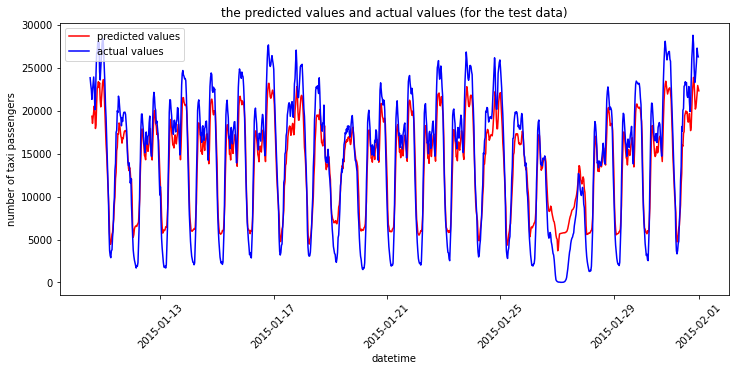

In [31]:
# predict results of test_df
new_pred_df = new_pipeline.predict(test_df)
plot_result(test_df, new_pred_df)

In [32]:
# evaluate test_df
mse, smape = new_pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is 7431303.533137466
Evaluate: the smape value is 12.900602163123525


## 6. multi step forecasting 

You can do multi step forecasting by simply changing the `future_seq_len` option while creating a new `TimeSequencePredictor` object.

In [33]:
# build time sequence predictor
from zoo.automl.regression.time_sequence_predictor import *

# change future_seq_len into the step you want to forcast.
tsp = TimeSequencePredictor(future_seq_len=5,
                            dt_col="datetime",
                            target_col="value",
                            extra_features_col=None)

In [34]:
%%time
# you can specify the look back sequence length with a single number or a range of (min_len, max_len) in RandomRecipe.
pipeline = tsp.fit(train_df,
                   validation_df=val_df,
                   metric="mse",
                   recipe=RandomRecipe(look_back=10))
print("Training completed.")

Trial name,status,loc,batch_size,dropout,dropout_1,dropout_2,latent_dim,lr,lstm_1_units,lstm_2_units,model,selected_features,iter,total time (s)
train_func_00000,TERMINATED,,32,0.228852,0.344078,0.323559,32,0.00420505,128,128,Seq2seq,"[""IS_WEEKEND(datetime)"", ""DAY(datetime)"", ""MONTH(datetime)"", ""IS_AWAKE(datetime)""]",10,137.825


best log dir is  /Users/liuruolan/ray_results/automl/train_func_0_batch_size=32,dropout=0.22885,dropout_1=0.34408,dropout_2=0.32356,latent_dim=32,lr=0.0042051,lstm_1_units=128,lstm_2__2020-06-04_10-13-05rzg130j4
The best configurations are:
selected_features : ["IS_WEEKEND(datetime)", "DAY(datetime)", "MONTH(datetime)", "IS_AWAKE(datetime)"]
model : Seq2seq
lstm_1_units : 128
dropout_1 : 0.3440775917607546
lstm_2_units : 128
dropout_2 : 0.3235592421892617
latent_dim : 32
dropout : 0.22885157055596117
lr : 0.004205051865070756
batch_size : 32
epochs : 5
past_seq_len : 10
Training completed.
CPU times: user 7 s, sys: 1.15 s, total: 8.15 s
Wall time: 2min 27s


In [35]:
# test
# predict test_df with the best trial
pred_df = pipeline.predict(test_df)

In [36]:
pred_df.head(5)

,datetime,value_0,value_1,value_2,value_3,value_4
0,2015-01-10 17:00:00,18542.748965,16855.870682,15963.209363,15042.154737,13161.327952
1,2015-01-10 17:30:00,20327.355148,17833.397265,15923.903421,14506.621512,12773.789841
2,2015-01-10 18:00:00,23609.464611,20921.756411,17788.181117,15512.600179,14435.544014
3,2015-01-10 18:30:00,25104.505100,22283.230748,19730.232241,17627.502560,16302.870351
4,2015-01-10 19:00:00,24662.556845,21833.584480,20027.303856,18577.041676,17463.836953


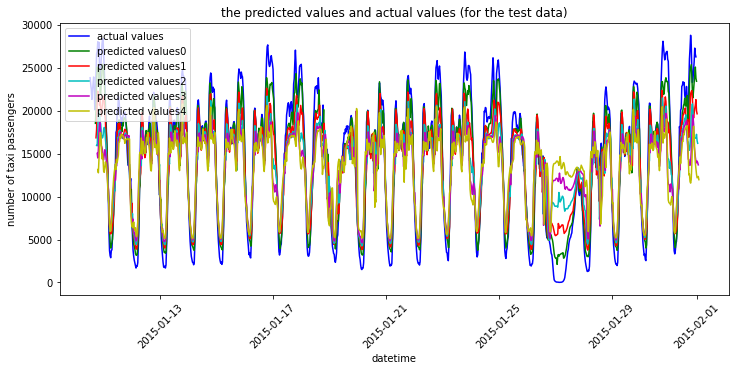

In [37]:
# plot multi step predicted values and actual values
# plot at most five step predict values for better view
plot_less_five_step_result(test_df, pred_df)

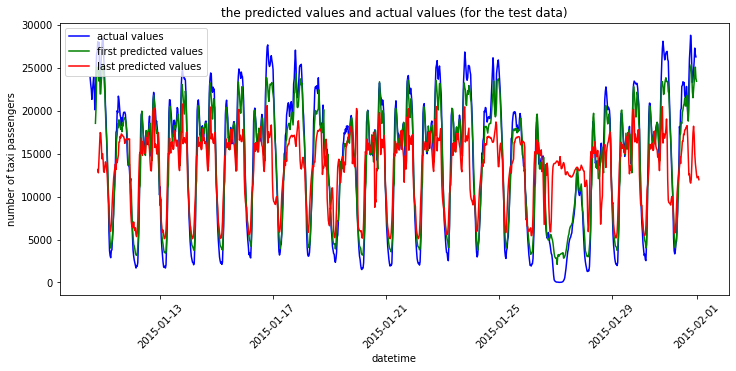

In [38]:
# plot only the first and the last step predict values and actual values
plot_first_last_step_result(test_df, pred_df)

In [39]:
# evaluate test_df
mse, smape = pipeline.evaluate(test_df, metrics=["mse", "smape"])
print("Evaluate: the mean square error is", mse)
print("Evaluate: the smape value is", smape)

Evaluate: the mean square error is [ 3001355.59252187  8712424.62229468 16119209.06607887 22648909.79607123
 27464028.83329645]
Evaluate: the smape value is [ 8.6700868  12.28125132 15.07722017 17.12824448 18.42701639]


In [40]:
ray_ctx.stop()